# eBay Assistant v2 | Development Notebook

In [1]:
import os
import pandas as pd
import numpy as np
from dotenv import load_dotenv
load_dotenv()
import openai
from IPython.display import Markdown, display, HTML, Image

os.chdir(os.path.dirname(os.getcwd()))

In [42]:
from marvin.beta.assistants import Assistant, Thread, CodeInterpreter

In [28]:
from src.utils import llm
from src.doc_store.ebay_scraper import eBayWebSearch, AverageSalePrice, eBayProduct

* Test "query" based on an item description from the existing app

In [6]:
query = 'Vintage Appleton Industrial Vented Light Fixture'

* The `AverageSalePrice` function searches the eBay API for sold items matching a description
* It excludes extreme outliers, then calculates average selling price (broken down by item cost & shipping) across all results
* Filters can be adjusted as needed, and the actual items can be brought in as well

In [6]:
averagePrice = AverageSalePrice(query=query, country='us', condition='all')
print(averagePrice)

Item Description: Vintage Appleton Industrial Vented Light Fixture
Average Price (based on 54 sold items):
* Item: $43.33 ($2.886 to $113.5)
* Shipping: $15.98 ($0.0 to $45.12)
* Total: $59.31


In [10]:
def get_pricing_stats(item: str) -> str:
    """Fetch the average selling price for a given item"""
    return str(AverageSalePrice(query=item, country='us', condition='all'))

In [12]:
ai = Assistant(tools=[get_pricing_stats])

run = ai.say(
    f"Please fetch pricing stats on the following item and summarize the results. Run the original item along with 2 other variations that you modified in a SEO way.\nORIGINAL ITEM: {query}",
)

Output()

Output()

In [16]:
def search_listings(query: str):
    """Run an eBay search query and return the top 5 results"""
    search_results = eBayWebSearch(query)
    return str(search_results[:4])

In [17]:
ai = Assistant(tools=[search_listings])

run = ai.say(
    f"Please search eBay listings for the following item and summarize the results as a nicely formatted and structred report\nITEM: {query}",
)

Output()

Output()

In [22]:
target_image = "https://i.ebayimg.com/thumbs/images/g/9QwAAOSwpDlluDud/s-l300.jpg"
display(Image(url=target_image))

In [32]:
import marvin
from pydantic import BaseModel, Field


class eBayListingItem(BaseModel):
    """An item for sale on eBay"""
    title: str = Field(description="A concise tag-line style title for the item.")
    inspection: str = Field(description="A detailed inspection of the item in the image. It should be particularly detailed on anything that impact the price.")
    seo_style_ebay_listing: str = Field(description="A SEO focused compelling description of the item. It should be engaging and interestig to read while staying true to the item. ")
    
    def __str__(self):
        return f"# {self.title}\n\n**Description:**\n{self.seo_style_ebay_listing}\n\nDetails: {self.inspection}"
        

img = marvin.beta.Image(
    target_image
)
result = marvin.beta.cast(
    data=img, 
    target=eBayListingItem,
    instructions="You are a wold class eBay seller, an expert at vividly describing items and crafting irresistable listing descriptions.",
)

# Authentic Vintage Industrial Pendant Light with Patina Finish

**Description:**
Step back in time with this genuine vintage industrial pendant light, a testament to historical craftsmanship. Its patina finish and authentic wear tell a story of a bygone era, making it a perfect statement piece for any antique lover or interior designer seeking to add a touch of industrial charm to their space. The ribbed glass diffuser casts a warm, inviting glow, ideal for creating ambiance in a dining room or study. While it bears the marks of time with some rust and paint loss, these imperfections only enhance its character. Note: This fixture may require rewiring for safe operation, a small investment for such a unique and timeless piece.

Details: The vintage industrial hanging light fixture features a patina finish that authenticates its age. The conical metal top has a red label with faded white lettering, indicating a historical warning or product label, now partially illegible. The clear, ribbed glass diffuser is in excellent condition, showing minimal signs of wear. Rust and paint loss are present on the metal parts, contributing to the item's vintage appeal. The threaded metal piece at the bottom suggests it was designed for secure attachment to an electrical box. Exposed wiring is noted, implying that rewiring or professional inspection may be necessary for functionality.

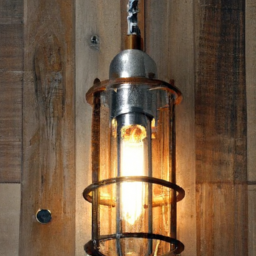

In [41]:
image_test = llm.prompt_image_gen(
    prompt=str(result.seo_style_ebay_listing),
    model="dall-e-2",
    size_category="small",
    style="natural",
)
image_path = image_test.get('file_path')
display(Markdown(str(result)))
display(Image(filename=image_path))